In [1]:
from IPython import display
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fln, fln2, Logistic
from tqdm.notebook import tqdm
import numpy.random as npr
from utilsNew import *

In [2]:
import matplotlib.pyplot as plt
import pickle

In [3]:
cudaid = 2
torch.cuda.set_device(cudaid)
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [5]:
def emfRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    Ynew = Y.clone()
    Rb = (1-R.to_dense()).to_sparse()
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        # estimate Y at current parameters
        Yhat = X.to_dense().matmul(betaOld) + bThetaOld
        probs = Logistic(Yhat)
        # impute the missing terms with estimated value
        Ynew[Rb.to_dense().bool()] = probs[Rb.to_dense().bool()] 
        
        t0 = time.time()
        LvNow = emLossL(bThetaOld, betaOld, f, X, Ynew, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = emLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Ynew)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = emLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Ynew)
        t3 = time.time()
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    #res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [6]:
def marfRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        #LvNow = marLinearLossL(X, Y, R, bThetaOld, betaOld, sigma=sigmaY) 
        LvNow = marLossL(bThetaOld, betaOld, f, X, Y, R, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = marLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R)
        betaNewRaw = betaOld - etab * LpbvOld
        #betaNewRaw = marLinearUpdateBeta(X, Y, R, bThetaOld)
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = marLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R)
        #bThetaNewRaw = marLinearUpdateTheta(X, Y, R, bThetaOld, betaNew)
        t3 = time.time()
        #svdres = torch.svd(bThetaNewRaw)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    #res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [7]:
def fRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        LvNow = lossLBern(bThetaOld, betaOld, f, X, Y, R, prob=prob, fct=fct, is_logf=False)
        
        t1 = time.time()
        # update beta
        LpbvOld = lossLpbBern(bThetaOld, betaOld, conDenfs[:3], X, Y, R, prob=prob, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = lossLpTBern(bThetaOld, betaNew, conDenfs[:3], X, Y, R, prob=prob, fct=fct)
       
        t3 = time.time()
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    #res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [8]:
def genR2(Y, D=3):
    probs = torch.zeros_like(Y)
    Ystd = Y - torch.mean(Y)
    probs = torch.exp(Ystd - D)
    probs = probs/(1 + probs)
    #probs[Ystd<0]
    uniSps = torch.rand_like(probs)
    R = uniSps <= probs
    R = R.type_as(Y).to_sparse()
    return R

In [9]:
n = m = 100
p = 2
prob = 0.2

sigmaY = 5.0

# generate the parameters
beta0 = torch.tensor([1.0, -2.0])
bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
initbetapref = 1 + (torch.rand(p)-1/2)/1 #[0.875, 1.125]
initthetapref = 1 + (torch.rand(n, m)-1/2)/4
betainit = beta0 * initbetapref
bThetainit = bTheta0 * initthetapref

X = genXBin(n, m, p, prob=prob) 
Y = genYnorm(X, bTheta0, beta0, sigmaY)
R = genR2(Y, D=6.8)
R.to_dense().mean()

tensor(0.1032)

In [10]:
def f(y, m, bsXs=None, sigma=sigmaY):
    return fn(y, m, bsXs, sigma)
def f2(y, m, bsXs=None, sigma=sigmaY):
    return fn(y, m, bsXs, sigma)
conDenfs = [f, f2, fn22]

In [12]:
tol = 1e-6
tolT = 0
tolb = 0

### Simu 

In [13]:
optParasMNAR = {}
optParasMNAR[12800] = [1e-3, 0,  1e2, 1.7*12] # 1600
optParasMNAR[6400] = [1e-3, 0,  1e2, 1.7*6] # 1600
optParasMNAR[3200] = [1e-3, 0,  1e2, 1.7*3] # 1600
optParasMNAR[1600] = [1e-3, 0,  1e2, 1.7*1.8] # 1600
optParasMNAR[800] = [1e-3, 0,  1e2, 1.7*1.2] # 800
optParasMNAR[400] = [1e-3, 0,  1e2, 1.7/1.5] # 400
optParasMNAR[200] = [1e-3, 0,  1e2, 1.7/2] # 200
optParasMNAR[100] = [1e-3, 0,  1e2, 1.7/2] # 100

optParas = {}
optParas[12800] = [1e-3, 0,  1e2, 1.7*0.84]
optParas[6400] = [1e-3, 0,  1e2, 1.7*0.84]
optParas[3200] = [1e-3, 0,  1e2, 1.7*0.84] 
optParas[1600] = [1e-3, 0,  1e2, 1.7*0.86] # 1600
optParas[800] = [1e-3, 0,  1e2, 1.7*0.88] # 800
optParas[400] = [1e-3, 0,  1e2, 1.7*0.92] # 400
optParas[200] = [1e-3, 0,  1e2, 1.7*0.96] # 200
optParas[100] = [1e-3, 0,  1e2, 1.7] # 100

In [14]:
fct = 1
emFcts = [7, 6, 5, 4, 3, 2, 1.5, 1]
flag =  7
for n in [12800]:
    m = n
    
    beta0 = torch.tensor([1.0, -2.0])
    bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
    
    ressMAR = []
    ressEM = []
    ressMNAR = []
    paraX = optParas[n]
    paraXMNAR = optParasMNAR[n]
    for j in tqdm(range(50)):
        initbetapref = 1 + (torch.rand(p)-1/2)/4  
        initthetapref = 1 + (torch.rand(n, m)-1/2)/4
        betainit = beta0 * initbetapref
        bThetainit = bTheta0 * initthetapref
        X = genXBin(n, m, p, prob=prob) 
        Y = genYnorm(X, bTheta0, beta0, sigmaY)
        R = genR2(Y, D=6.8)
        resEM = emfRun(R, CT=paraX[0], Cb=paraX[1], etaT=paraX[2]/emFcts[flag], etab=paraX[3]/10, maxIter=100, is_plot=0, is_showPro=0)
        resMAR = marfRun(R, CT=paraX[0], Cb=paraX[1], etaT=paraX[2], etab=paraX[3], maxIter=100, is_plot=0, is_showPro=0)
        resMNAR = fRun(R, CT=paraXMNAR[0], Cb=paraXMNAR[1], etaT=paraXMNAR[2], etab=paraXMNAR[3], maxIter=100, is_plot=0, is_showPro=0)
        if n <= 6400:
            ressMAR.append(resMAR)
            ressEM.append(resEM)
            ressMNAR.append(resMNAR)
        else:
            ressMNAR.append((np.linalg.norm(beta0.cpu().numpy()-resMNAR["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resMNAR["bTheta"])))
            ressMAR.append((np.linalg.norm(beta0.cpu().numpy()-resMAR["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resMAR["bTheta"])))
            ressEM.append((np.linalg.norm(beta0.cpu().numpy()-resEM["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resEM["bTheta"])))
    
    flag += 1
    ressDic = {}
    ressDic["ressEM"] = ressEM
    ressDic["ressMAR"] = ressMAR
    ressDic["ressMNAR"] = ressMNAR
    ressDic["beta0"] = beta0
    ressDic["bTheta0"] = bTheta0
    with open(f"./JMLRR2_linearSmallp_n{n}.pkl", "wb") as wf:
        pickle.dump(ressDic, wf)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
errssMARs = []
errssEMs = []
errssMNARs = []
ns = [100, 200, 400, 800, 1600, 3200, 6400]
for n in ns:
    with open(f"./JMLRR2_linearSmallp_n{n}.pkl", "rb") as rf:
        ressDic = pickle.load(rf)
        
    errs = [(np.linalg.norm(res["beta"]-ressDic["beta0"].cpu().numpy()), np.linalg.norm(res["bTheta"]-ressDic["bTheta0"].cpu().numpy())) for res in ressDic["ressMAR"]]
    errssMARs.append(np.array(errs))
    errs = [(np.linalg.norm(res["beta"]-ressDic["beta0"].cpu().numpy()), np.linalg.norm(res["bTheta"]-ressDic["bTheta0"].cpu().numpy())) for res in ressDic["ressMNAR"]]
    errssMNARs.append(np.array(errs))
    errs = [(np.linalg.norm(res["beta"]-ressDic["beta0"].cpu().numpy()), np.linalg.norm(res["bTheta"]-ressDic["bTheta0"].cpu().numpy())) for res in ressDic["ressEM"]]
    errssEMs.append(np.array(errs))

In [34]:
errEMmean =  np.array([res.mean(axis=0) for res in errssEMs])
errMARmean =  np.array([res.mean(axis=0) for res in errssMARs])
errMNARmean = np.array([res.mean(axis=0) for res in errssMNARs])

In [17]:
with open(f"./JMLRR2_linearSmallp_n12800.pkl", "rb") as rf:
    ressDic = pickle.load(rf)

In [35]:
errEMmean = np.concatenate([errEMmean, np.mean(ressDic["ressEM"], axis=0).reshape(-1, 2)], axis=0)
errMARmean = np.concatenate([errMARmean, np.mean(ressDic["ressMAR"], axis=0).reshape(-1, 2)], axis=0)
errMNARmean = np.concatenate([errMNARmean, np.mean(ressDic["ressMNAR"], axis=0).reshape(-1, 2)], axis=0)

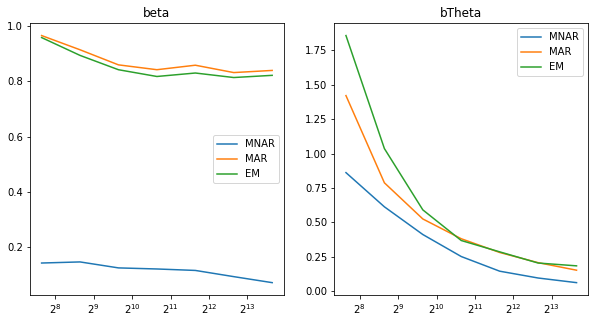

In [39]:
ns = [200, 400, 800, 1600, 3200, 6400, 12800]
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title("beta")
plt.plot(ns, errMNARmean[1:, 0], "-", label="MNAR")
plt.plot(ns, errMARmean[1:, 0], "-", label="MAR")
plt.plot(ns, errEMmean[1:, 0], "-", label="EM")
plt.xscale("log", base=2)
plt.legend()

plt.subplot(122)
plt.title("bTheta")
plt.plot(ns, (errMNARmean[1:, 1]), label="MNAR")
plt.plot(ns, (errMARmean[1:, 1]), label="MAR")
plt.plot(ns, errEMmean[1:, 1], label="EM")
plt.xscale("log", base=2)
plt.legend()